In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from textblob import TextBlob
from nltk import ngrams
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import string
from imblearn.over_sampling import SMOTE

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
df = pd.read_csv("drugsComTrain_raw.csv")

In [5]:
df.head()

uniqueID                  drugName                     condition  \
0    206461                 Valsartan  Left Ventricular Dysfunction   
1     95260                Guanfacine                          ADHD   
2     92703                    Lybrel                 Birth Control   
3    138000                Ortho Evra                 Birth Control   
4     35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  "It has no side effect, I take it in combinati...       9  20-May-12   
1  "My son is halfway through his fourth week of ...       8  27-Apr-10   
2  "I used to take another oral contraceptive, wh...       5  14-Dec-09   
3  "This is my first time using any form of birth...       8   3-Nov-15   
4  "Suboxone has completely turned my life around...       9  27-Nov-16   

   usefulCount  
0           27  
1          192  
2           17  
3           10  
4           37

#### Description of DataFrame Columns:

**uniqueID:** Each record in the dataset has a unique identification.

**drugName:** The name of the drug about which the review is written.

**condition:** The medical problem or sickness that the medicine was recommended or used to treat.

**review:** The written review of the drug offered by the user or patient.

**rating:** A numerical score given by the user, usually on a scale (e.g., 1 to 10), indicates the drug's effectiveness or satisfaction.

**date:** The date the review was published.

**usefulCount:** A count of how many people thought the review informative or helpful.



## EDA and Visualization

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     161297 non-null  int64 
 1   drugName     161297 non-null  object
 2   condition    160398 non-null  object
 3   review       161297 non-null  object
 4   rating       161297 non-null  int64 
 5   date         161297 non-null  object
 6   usefulCount  161297 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 8.6+ MB


In [7]:
df.describe()

uniqueID         rating    usefulCount
count  161297.000000  161297.000000  161297.000000
mean   115923.585305       6.994377      28.004755
std     67004.445170       3.272329      36.403742
min         2.000000       1.000000       0.000000
25%     58063.000000       5.000000       6.000000
50%    115744.000000       8.000000      16.000000
75%    173776.000000      10.000000      36.000000
max    232291.000000      10.000000    1291.000000

#### Observation:
1. The **uniqueID** is unqiue identification number so there is no use of that column.
2. The **rating** column contains values ranging from 1 to 10. The average score is around 7, with a median of 8. This indicates that the majority of the reviews are good. The 25th percentile number is 5, indicating that 75% of the reviews are rated 5 or above.
3. The **usefulCount** column shows how many users considered a specific helpful review. An appraisal is valuable to 28 people on average. This column's value ranges from 0 (indicating that some studies were not useful to anyone) to 1291. The median is 16, meaning half of the reviews were helpful to 16 or fewer users. The 75th percentile number is 36, suggesting that over 36 individuals found the top 25% of reviews beneficial. The standard deviation is around 36.4, showing that the number of times evaluations were judged valuable varied widely.


In [8]:
df.isnull().sum()

uniqueID         0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

Only **condition** column is having **899** NaN values rest of the columns are having useful information.

In [9]:
df['condition'].fillna('Unknown', inplace=True)

We have filled NaN with **Unknown** in condition column

In [10]:
df.isnull().sum()

uniqueID       0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [11]:
df.duplicated().sum()

0

There are no duplicates in dataset 

#### Text Pre-processing

In [12]:
def tokenize_text(text):
    return word_tokenize(text)

def lowercase_text(text):
    return text.lower()

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [token for token in tokens if token not in stop_words]

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)


def lemmatize_text(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

def preprocess_text(column):
    column = column.apply(lowercase_text)
    column = column.apply(remove_punctuation)
    column = column.apply(tokenize_text)
    column = column.apply(remove_stopwords)
    column = column.apply(lemmatize_text)
    return column

In [13]:
df.review.isnull().value_counts()

False    161297
Name: review, dtype: int64

In [14]:
df['unprocessed_review'] = df['review']
df["review"] = preprocess_text(df["review"])

#### Processing Reviews

**tokenize_text:** This function splits a provided text into individual words using the word_tokenize technique, converting a sentence or paragraph into a list of words.

**lowercase_text:** Lowercase all characters in the text. This ensures that terms like "The" and "the" are recognized as synonymous, removing case-sensitivity concerns from the study.

**remove_stopwords:** Removes stopwords, commonly filtered out in textual analysis, because they appear regularly across all texts and do not provide unique insights. Stopwords include phrases like "and," "or," and "not."

**remove_punctuation:** Using a regular expression, removes punctuation marks from the text. Punctuation can bring noise into textual analysis, mainly when the focus is on words and their meanings rather than sentence structure.

**lemmatize_text:** This function uses the WordNet Lemmatizer to break down words into their base or root form. For example, "running," "ran," and "runner" might all be reduced to the base form "run." This aids in lowering the dimensionality of text data and recognizing the essential meaning of words regardless of how they are used.

Finally, the preprocess_text function is a wrapper that sequentially applies all of the preceding operations to a specific panda's DataFrame column. The primary purpose is to clean and standardize the text so that it may be used for further research or machine learning models. In 'unprocessed_review,' the original review column is kept, and the cleaned version replaces the review column.



In [15]:
df.head()

uniqueID                  drugName                     condition  \
0    206461                 Valsartan  Left Ventricular Dysfunction   
1     95260                Guanfacine                          ADHD   
2     92703                    Lybrel                 Birth Control   
3    138000                Ortho Evra                 Birth Control   
4     35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  [side, effect, take, combination, bystolic, 5,...       9  20-May-12   
1  [son, halfway, fourth, week, intuniv, became, ...       8  27-Apr-10   
2  [used, take, another, oral, contraceptive, 21,...       5  14-Dec-09   
3  [first, time, using, form, birth, control, i03...       8   3-Nov-15   
4  [suboxone, completely, turned, life, around, f...       9  27-Nov-16   

   usefulCount                                 unprocessed_review  
0           27  "It has no side effect, I take it in combinati...  
1          192  "My son is halfway through his fourth week of ...  
2           17  "I used to take another oral contraceptive, wh...  
3           10  "This is my first time using any form of birth...  
4           37  "Suboxone has completely turned my life around...

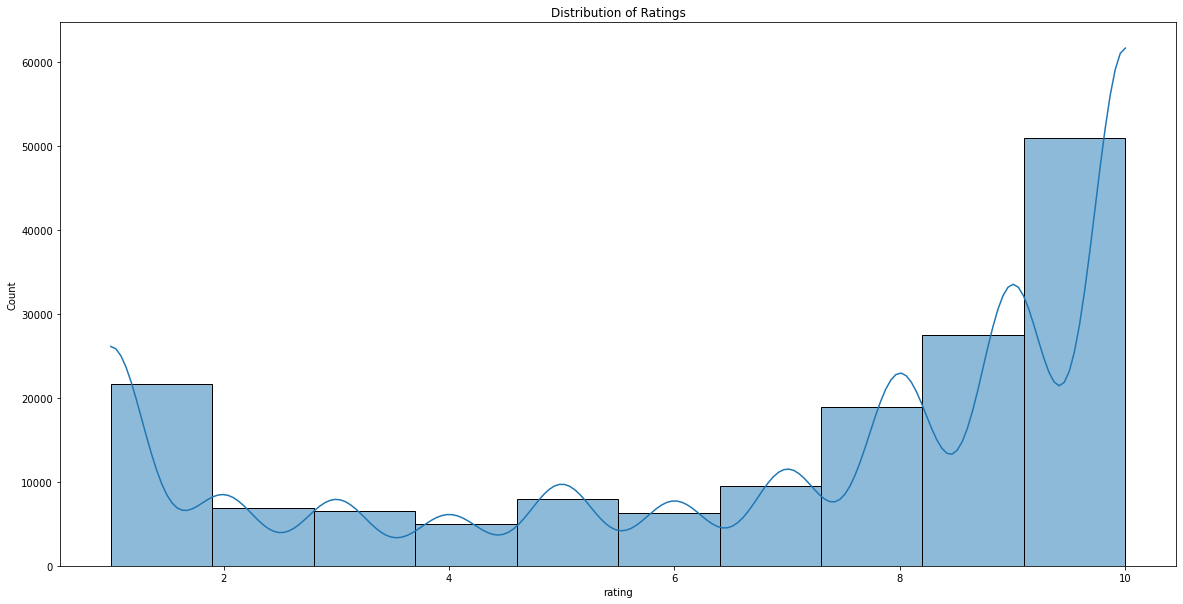

In [16]:
plt.figure(figsize=(20, 10))
sns.histplot(df['rating'], kde=True, bins=10)
plt.title('Distribution of Ratings')
plt.savefig("Images_Ass/dist-rating.png")

#### Observation:
- Ratings ranging from 1 to 2 indicate **high discontent** among customers.
- Ratings ranging from 8 to 10 indicate **strong contentment** among customers.
- Ratings ranging from 4 to 7 indicate **mixed or average feelings**.

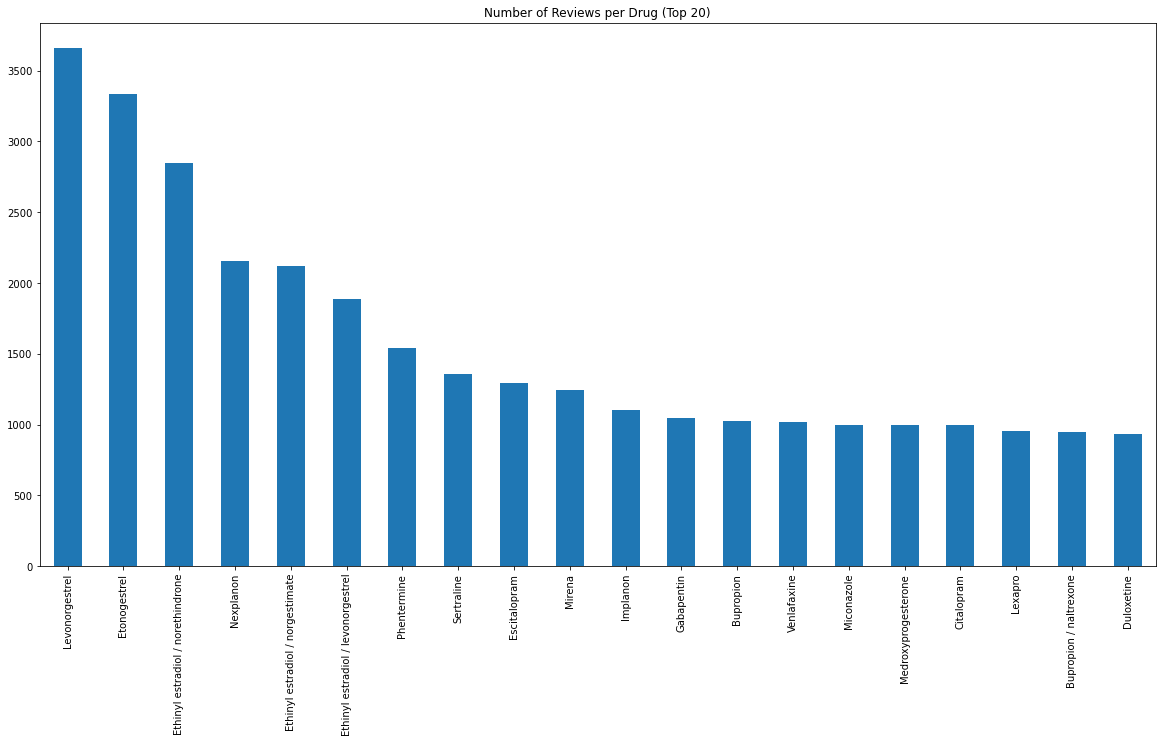

In [17]:
plt.figure(figsize=(20, 10))
df['drugName'].value_counts()[:20].plot(kind='bar')
plt.title('Number of Reviews per Drug (Top 20)')
plt.savefig("Images_Ass/top-20-drug-review.png")

#### Observation:
- With 3657 and 3336 reviews, respectively, "Levonorgestrel" and "Etonogestrel" are the most reviewed medications, showing significant user experience or widespread usage of these drugs.
- The majority of the pharmaceuticals on the list are associated with hormone treatments, antidepressants, and mood stabilisers, indicating a high prevalence of feedback or experiences shared for these prescription categories.


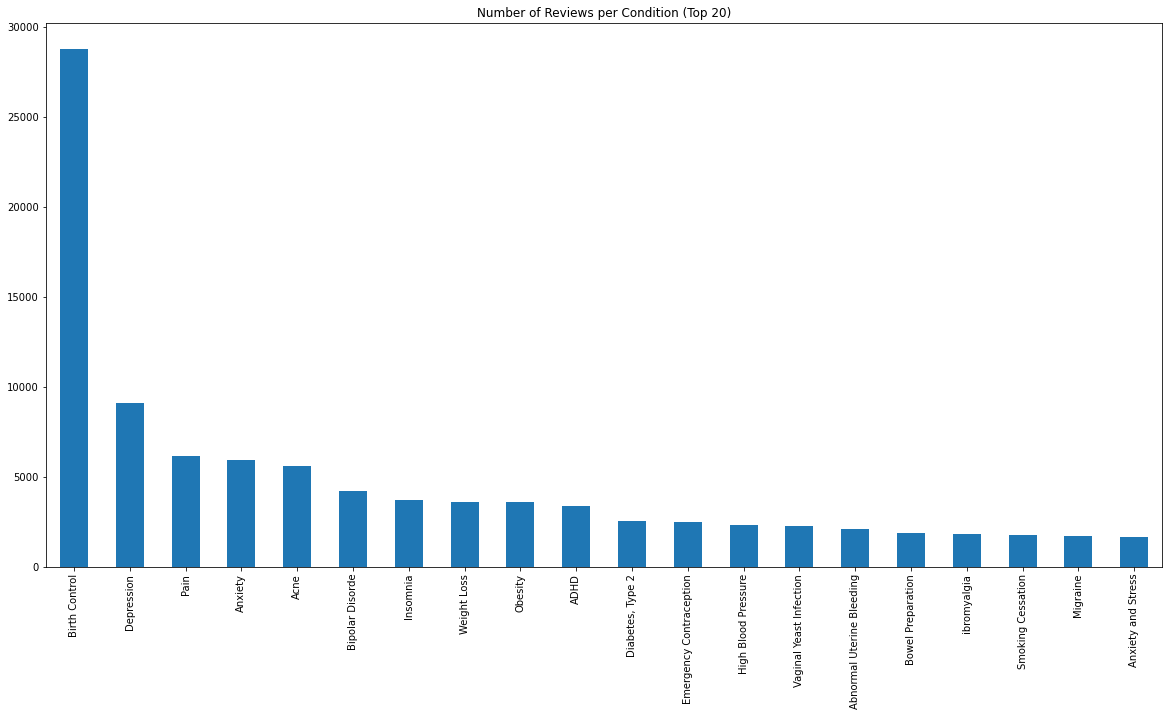

In [18]:
plt.figure(figsize=(20, 10))
df['condition'].value_counts()[:20].plot(kind='bar')
plt.title('Number of Reviews per Condition (Top 20)')
plt.savefig("Images_Ass/top-20-review-condition.png")

### Observations from Visualizations

#### Distribution of Ratings

The ratings in the dataset are skewed towards higher values, with a rating of 10 being the most common. This skewness could be attributed to people being more likely to leave reviews when they have an exceptionally positive experience with a drug.

#### Number of Reviews per Drug (Top 20)

The dataset shows that "Levonorgestrel" is the most reviewed drug, followed by "Etonogestrel" and "Ethinyl estradiol / norethindrone". This observation suggests that these drugs are either commonly prescribed or have a significant impact on users, prompting more reviews regarding their effectiveness or potential side effects.

#### Number of Reviews per Condition (Top 20)

The most common condition for which reviews are written is "Birth Control", followed by "Depression" and "Pain". This pattern may indicate that these conditions are prevalent among the population or that they significantly affect patients' lives, leading to more user feedback about their experiences with treatments.



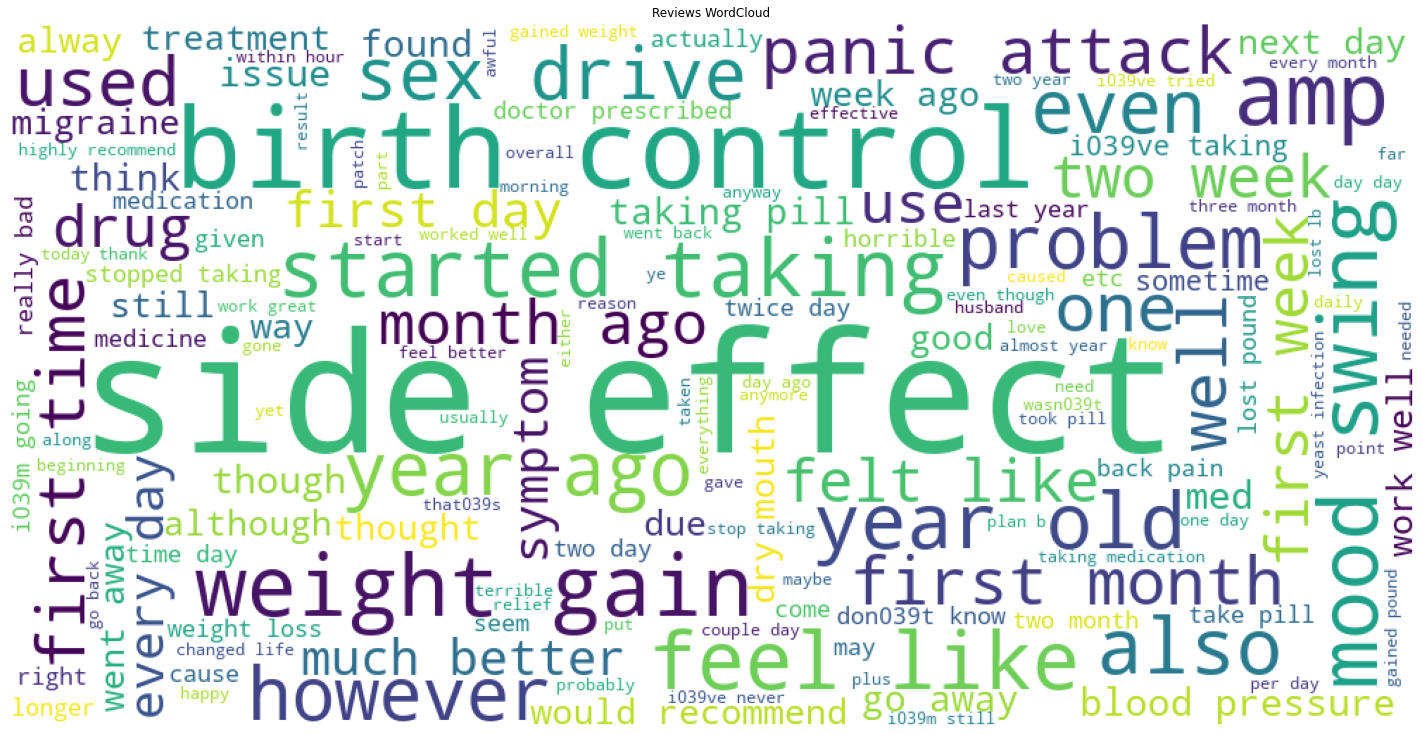

In [19]:
stop_words = set(stopwords.words('english'))
all_words = ' '.join([' '.join(review) for review in df['review']])
review_cloud = WordCloud(width=1000, height=500, background_color='white', stopwords=stop_words, min_font_size=10).generate(all_words)
                        
plt.figure(figsize = (20, 10), facecolor=None) 
plt.imshow(review_cloud) 
plt.axis("off")
plt.title("Reviews WordCloud")
plt.tight_layout(pad = 0)
plt.savefig("Images_Ass/Reviews-WordCloud.png")

In [20]:
positive_reviews = df[df['rating'] > 5]['review']
negative_reviews = df[df['rating'] <= 5]['review']

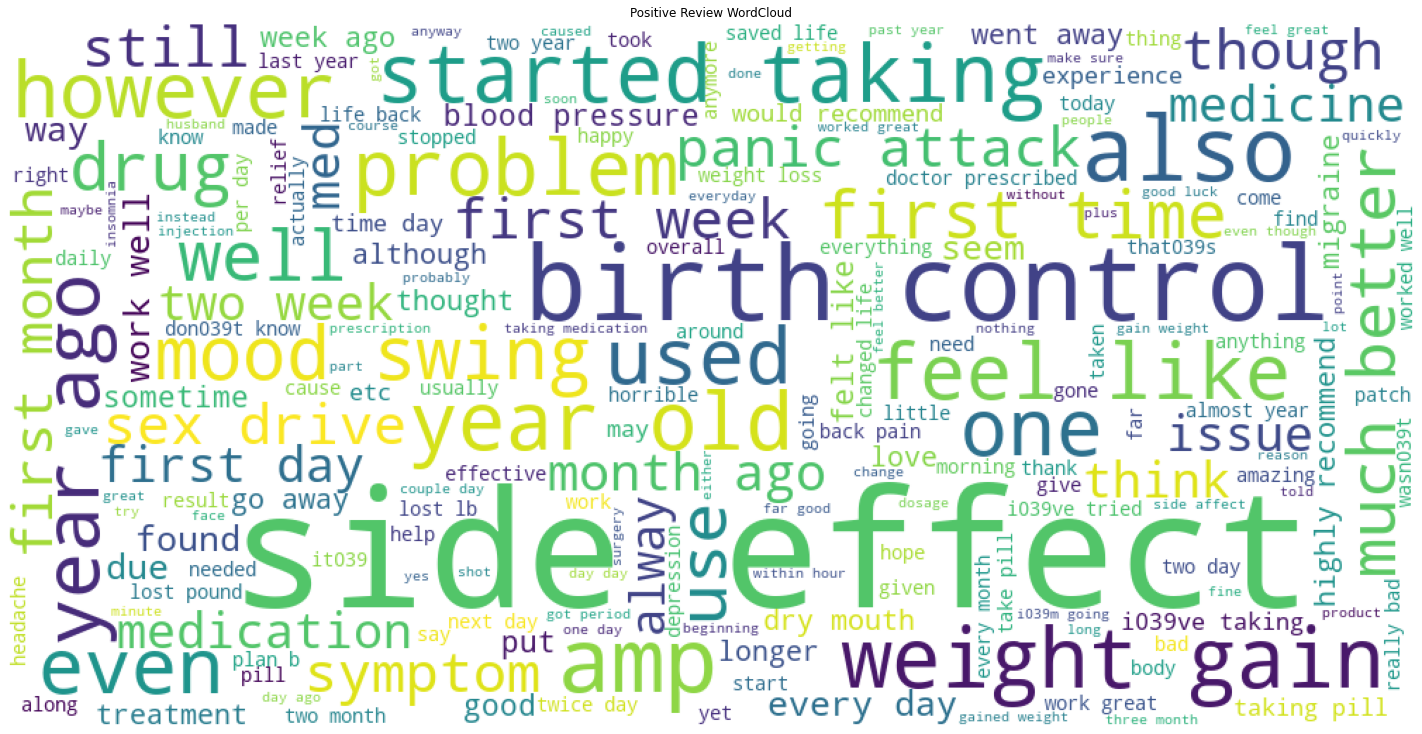

In [21]:
all_words = ' '.join([' '.join(review) for review in positive_reviews])
wordcloud = WordCloud(width = 1000, height = 500, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(all_words)                       
plt.figure(figsize = (20, 10), facecolor=None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title("Positive Review WordCloud")
plt.tight_layout(pad = 0)
plt.savefig("Images_Ass/Positive-Reviews-WordCloud.png")

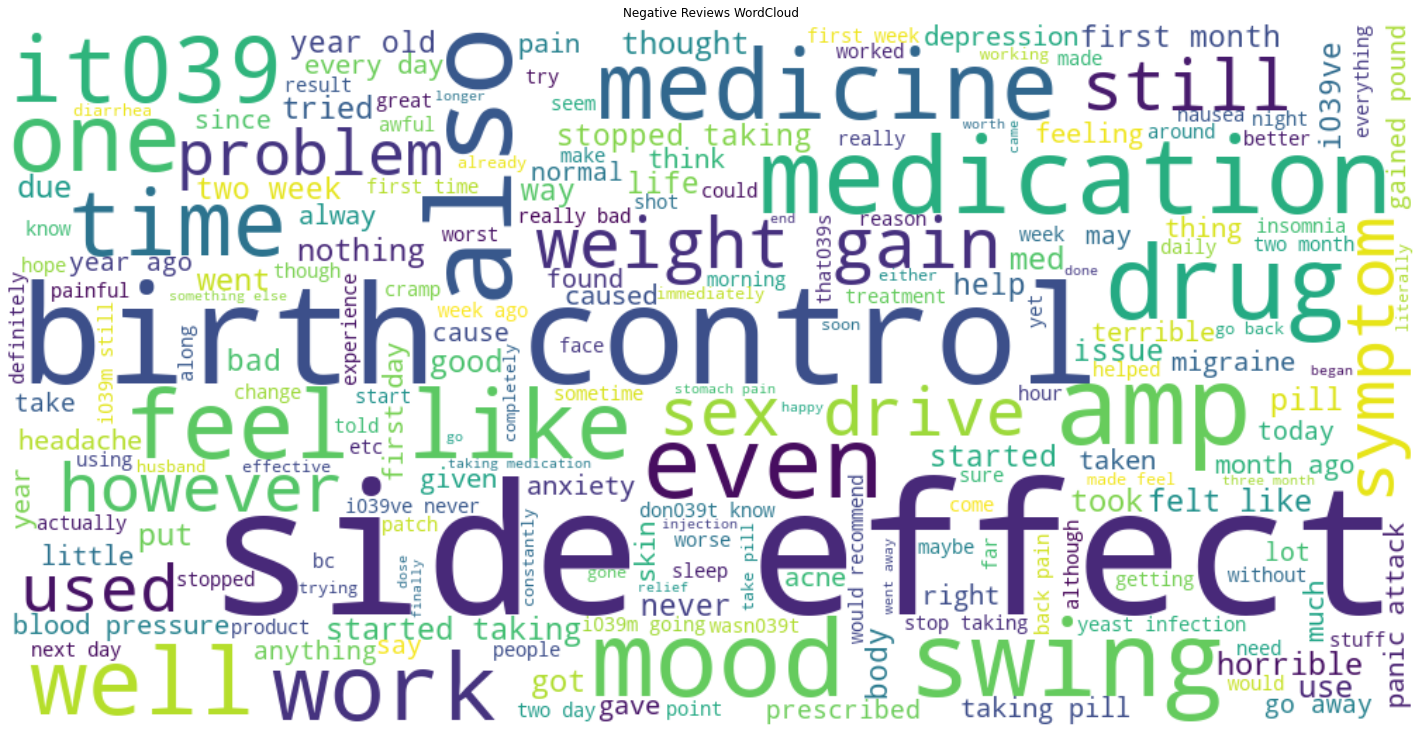

In [22]:
all_words = ' '.join([' '.join(review) for review in negative_reviews])
wordcloud = WordCloud(width = 1000, height = 500, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(all_words)                    
plt.figure(figsize = (20, 10), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.title("Negative Reviews WordCloud")
plt.tight_layout(pad = 0)
plt.savefig("Images_Ass/Negative-Reviews-WordCloud.png")

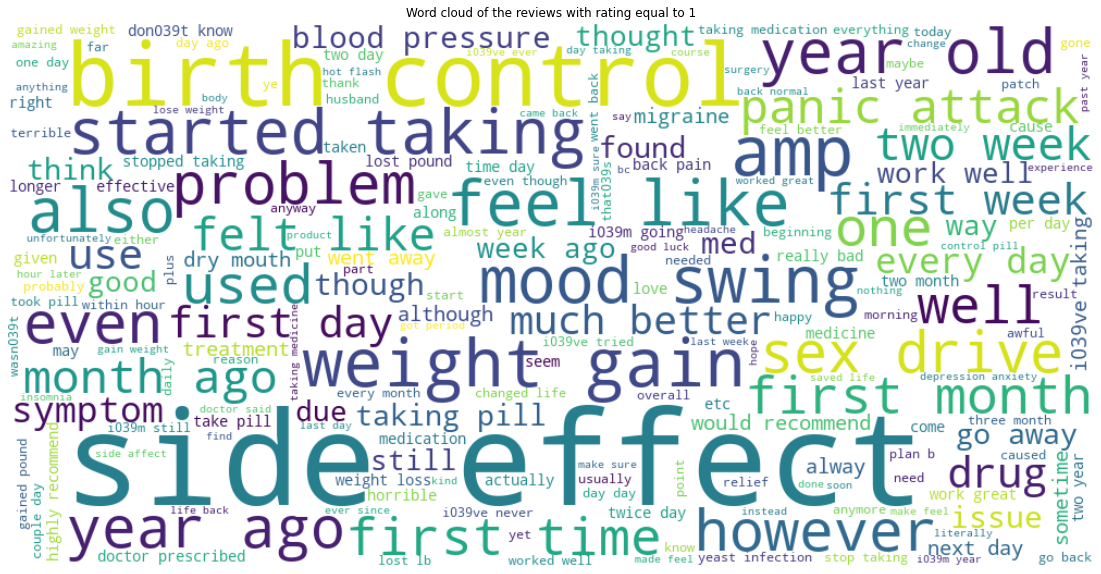

In [23]:
df_rate_one = df.loc[df.rating == 1, 'review']
review_1 = ' '.join([' '.join(review) for review in df['review']])

wordcloud = WordCloud(width = 1000, height = 500, background_color ='white', stopwords = stop_words, min_font_size = 10).generate(review_1)
plt.figure(figsize=(20, 10), facecolor=None)
plt.title("Word cloud of the reviews with rating equal to 1")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');
plt.savefig("Images_Ass/reivews-with-1-rating.png")

#### Observation of all the Word Clouds:
**Recurring Themes:** 
- Words like "Side Effect", "birth control", "weight gain", and "mood swing" indicate that many users are discussing the side effects of the medications, particularly those related to birth control. This suggests that adverse effects, particularly weight changes and mood swings, are frequently discussed in the evaluations.
**Duration & Consistency:** 
- The frequent use of phrases such as "day", "months", "first month", and "every day" suggests that users are discussing the duration of consumption, early experiences, or continuous daily use of the prescriptions.
**General Sentiment:** 
- Words like "feel like", "problem", and "taking" convey a personal experience or attitude related with the medicine. The presence of these terms in all types of reviews implies that people are sharing their own journeys, both happy and negative, with the site. 

##### Overall:
Given that these words appear in all categories of reviews (overall, good, negative, and one-star), it's clear that these are overarching themes and worries that people express when discussing their experiences with these prescriptions.


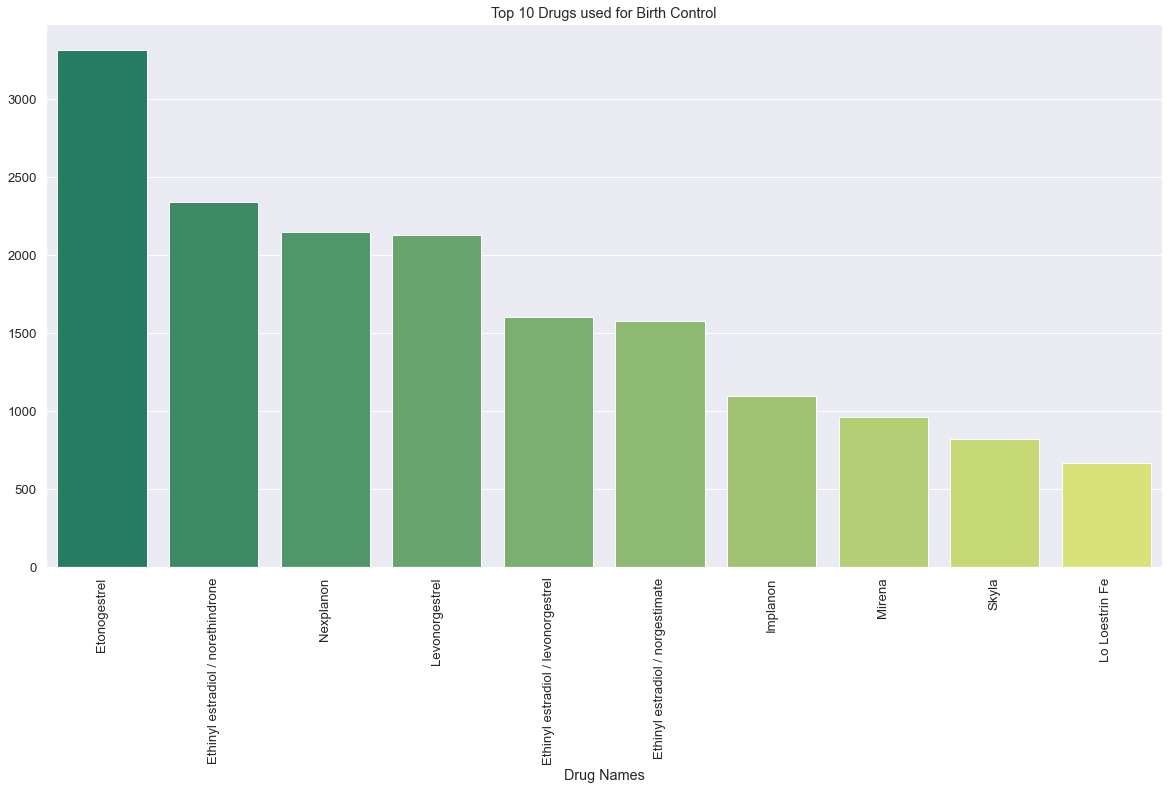

In [24]:
# Top 10 drugs which are used for the top condition, that is Birth Control

df_birth_control = df[df['condition'] == 'Birth Control']['drugName'].value_counts()[0: 10]
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.figure(figsize=(20, 10))
sns_ = sns.barplot(x = df_birth_control.index, y = df_birth_control.values, palette = 'summer')
plt.xlabel('Drug Names')
plt.title("Top 10 Drugs used for Birth Control")
plt.setp(sns_.get_xticklabels(), rotation = 90);
plt.savefig("Images_Ass/top-10-birth-control.png")

#### Observation:
- **Popularity and Usage:** With 3314 mentions, "Etonogestrel" is the most mentioned birth control pill, indicating that it may be one of the most popular or commonly used alternatives. This is closely followed by "Ethinyl estradiol / norethindrone" (2337 mentions) and "Nexplanon" (2149 mentions).

- **Variety of Options:** The list includes both single-component medications (such as "Etonogestrel" and "Nexplanon") and combination drugs (such as "Ethinyl estradiol / norethindrone"). This suggests that consumers are discussing and employing a wide range of birth control techniques, both in terms of active components and brand names.

- **Notable Brands:** Specific products such as "Nexplanon," "Implanon," and "Mirena" appear on the list as well, indicating that certain named birth control techniques have a large user base or are regularly discussed.


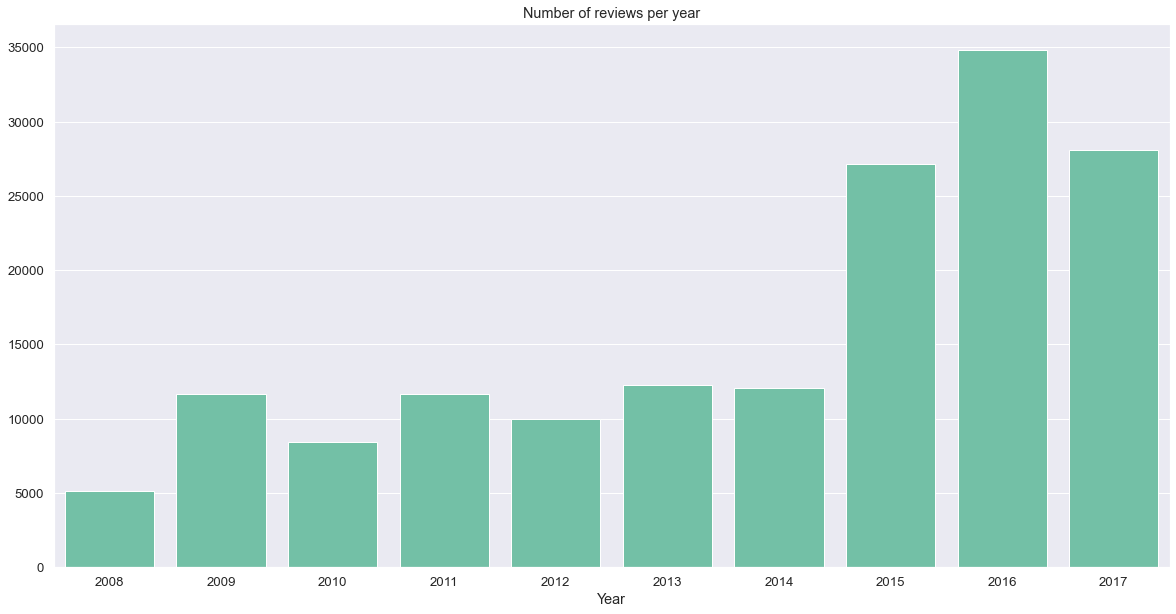

In [25]:
df['date'] = pd.to_datetime(df['date'])
df_year = df['date'].dt.year.value_counts()
df_year = df_year.sort_index()
plt.figure(figsize=(20, 10))
sns_ = sns.barplot(x = df_year.index, y = df_year.values, color = 'mediumaquamarine')
sns_.set_title("Number of reviews per year")
sns_.set_xlabel("Year")
plt.savefig("Images_Ass/reviews_year.png")

#### Observation:
- The number of reviews has clearly increased throughout the years, beginning in 2008 and culminating around 2016. 
- This could imply an increasing tendency of people expressing their drug experiences online, or a rise in the platform where these reviews are gathered. 
- The modest decrease in 2017 could be attributed to inadequate data for that year or other factors influencing the number of reviews.


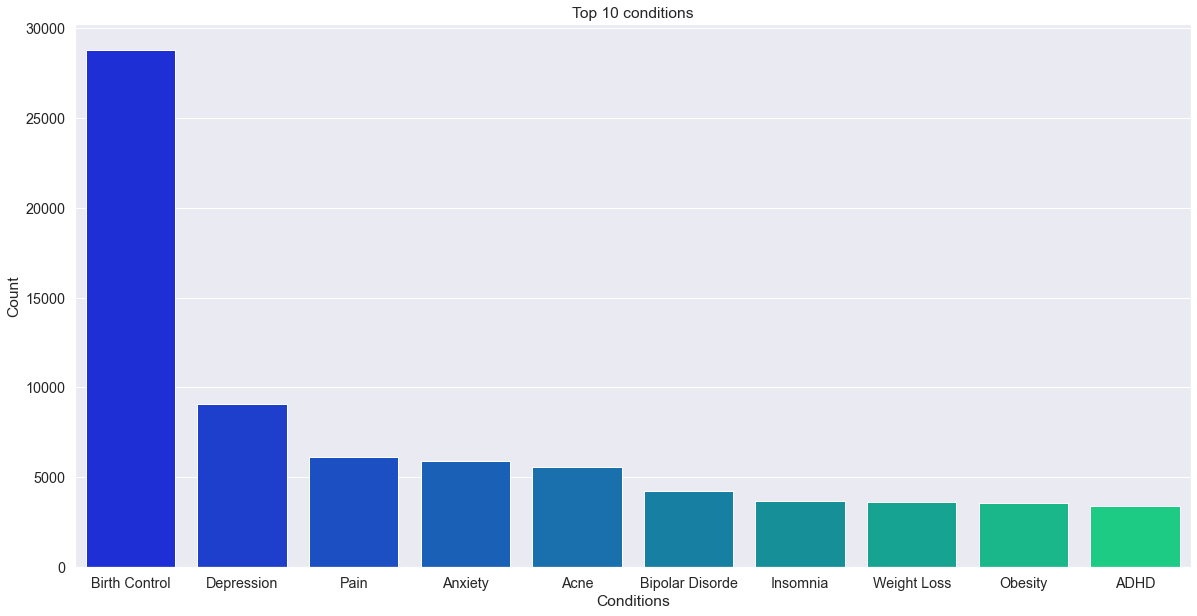

In [26]:
cond = dict(df['condition'].value_counts())
top_condition = list(cond.keys())[0:10]
values = list(cond.values())[0:10]
sns.set(style = 'darkgrid', font_scale = 1.3)
plt.figure(figsize=(20, 10))
plt.title("Top 10 conditions")
plt.xlabel("Conditions")
plt.ylabel("Count")
sns.barplot(x = top_condition, y = values, palette = 'winter')
plt.savefig("Images_Ass/top-conditions.png")

#### Observation:

- Reviews for the most common ailments include "Birth Control," "Depression," "Pain," and "Anxiety," among others. 
- "Birth Control" takes the lead by a wide margin, showing that a sizable number of users are discussing their experiences with birth control drugs. 
- The use of terms such as "Depression" and "Anxiety" implies that mental health treatments are commonly addressed medication.


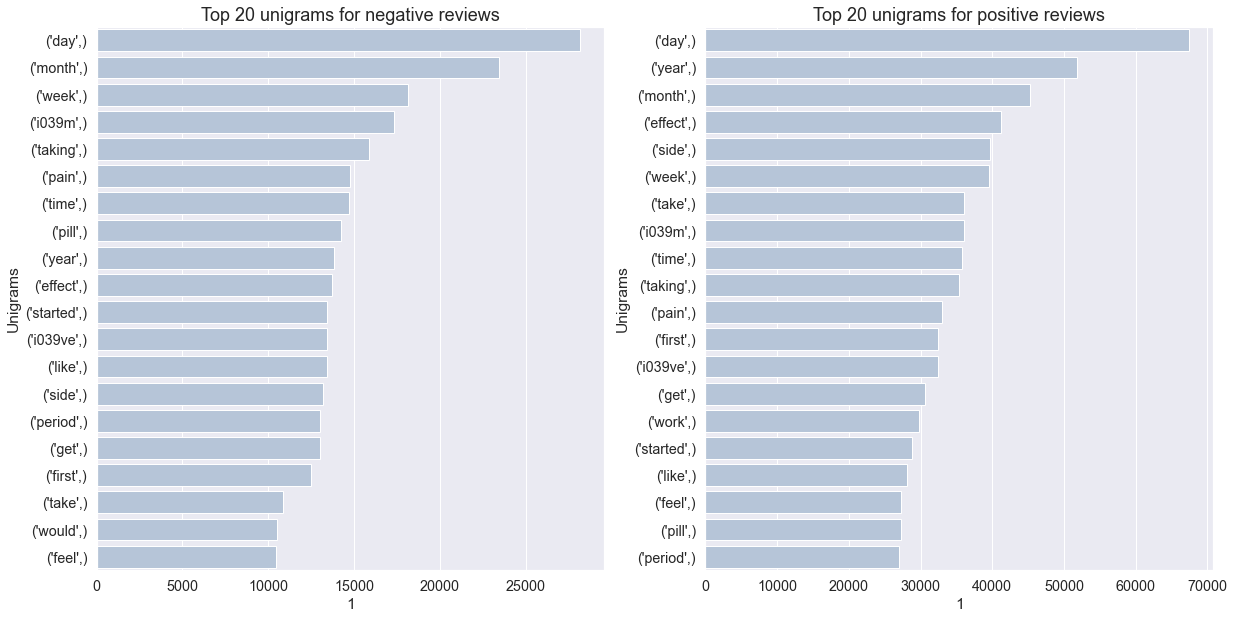

In [27]:
pos_words = ' '.join([' '.join(review) for review in positive_reviews])
neg_words = ' '.join([' '.join(review) for review in negative_reviews])
unigrams_negative = ngrams(word_tokenize(neg_words), 1)
unigrams_positive = ngrams(word_tokenize(pos_words), 1)

frequency_negative = Counter(unigrams_negative)
frequency_positive = Counter(unigrams_positive)

df_negative = pd.DataFrame(frequency_negative.most_common(20))
df_positive = pd.DataFrame(frequency_positive.most_common(20))

# Barplot that shows the top 20 unigrams
plt.rcParams['figure.figsize'] = [20,10]
fig, ax = plt.subplots(1,2)
sns.set(font_scale = 1.5, style = 'whitegrid')

neg = sns.barplot(x = df_negative[1], y = df_negative[0], color = 'lightsteelblue', ax = ax[0])
pos = sns.barplot(x = df_positive[1], y = df_positive[0], color = 'lightsteelblue', ax = ax[1])

# Setting axes labels
neg.set_title("Top 20 unigrams for negative reviews")
pos.set_title("Top 20 unigrams for positive reviews")
neg.set_ylabel("Unigrams")
pos.set_ylabel("Unigrams")
plt.savefig("Images_Ass/Unigram.png")

#### Reviews of Unigrams:

- We would expect to observe words associated with negative attitudes or adverse effects in unfavourable evaluations. Words such as "pain", "problem", "issue", "worst" and "bad" could be among the top unigrams.

- Words expressing happiness or favourable outcomes may predominate in positive reviews. Words like "good", "effective", "best", "happy", and "love" could be among the top unigrams.


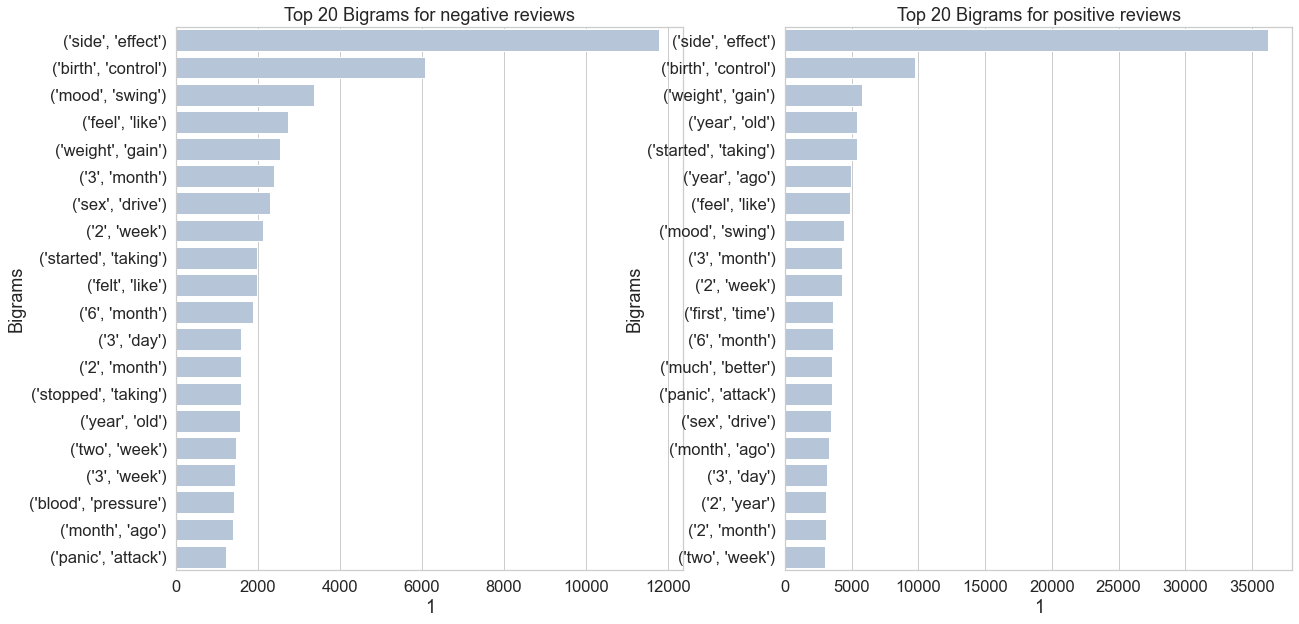

In [28]:
pos_words = ' '.join([' '.join(review) for review in positive_reviews])
neg_words = ' '.join([' '.join(review) for review in negative_reviews])
bigrams_negative = ngrams(word_tokenize(neg_words), 2)
bigrams_positive = ngrams(word_tokenize(pos_words), 2)

frequency_negative = Counter(bigrams_negative)
frequency_positive = Counter(bigrams_positive)

df_negative = pd.DataFrame(frequency_negative.most_common(20))
df_positive = pd.DataFrame(frequency_positive.most_common(20))

# Barplot that shows the top 20 unigrams
plt.rcParams['figure.figsize'] = [20,10]
fig, ax = plt.subplots(1,2)
sns.set(font_scale = 1.5, style = 'whitegrid')

neg = sns.barplot(x = df_negative[1], y = df_negative[0], color = 'lightsteelblue', ax = ax[0])
pos = sns.barplot(x = df_positive[1], y = df_positive[0], color = 'lightsteelblue', ax = ax[1])

# Setting axes labels
neg.set_title("Top 20 Bigrams for negative reviews")
pos.set_title("Top 20 Bigrams for positive reviews")
neg.set_ylabel("Bigrams")
pos.set_ylabel("Bigrams")
plt.savefig("Images_Ass/Bigrams.png")

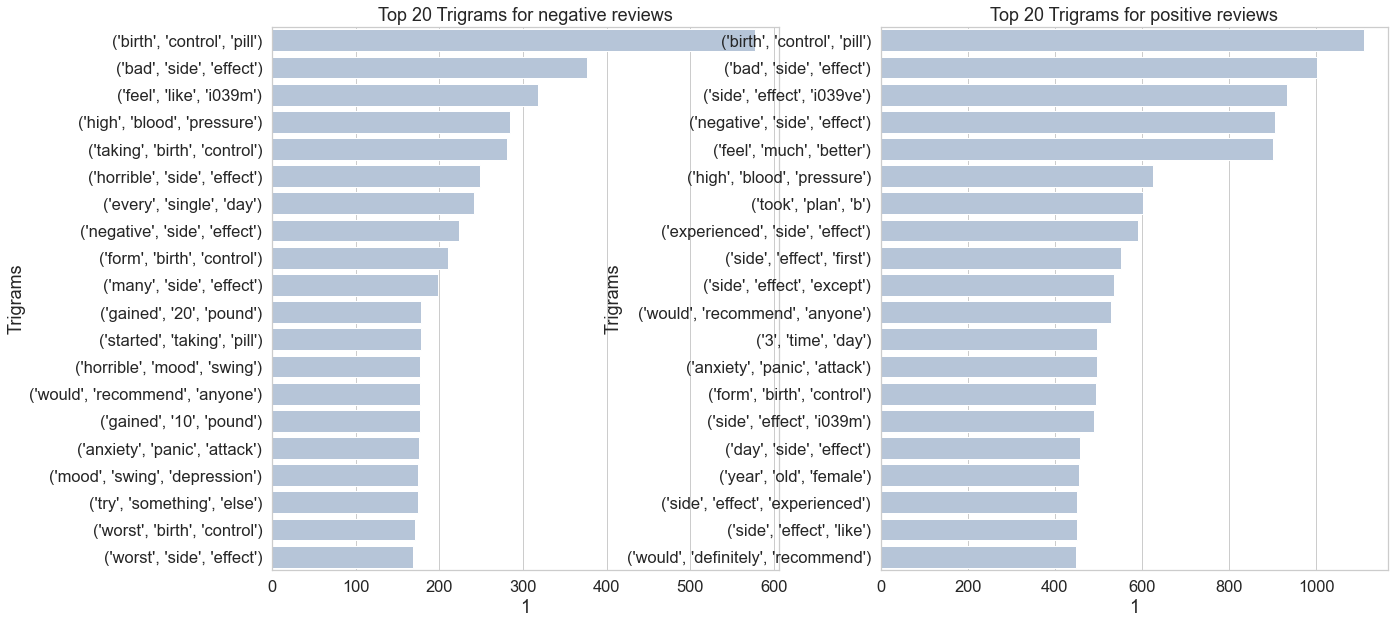

In [29]:
pos_words = ' '.join([' '.join(review) for review in positive_reviews])
neg_words = ' '.join([' '.join(review) for review in negative_reviews])
trigrams_negative = ngrams(word_tokenize(neg_words), 3)
trigrams_positive = ngrams(word_tokenize(pos_words), 3)

frequency_negative = Counter(trigrams_negative)
frequency_positive = Counter(trigrams_positive)

df_negative = pd.DataFrame(frequency_negative.most_common(20))
df_positive = pd.DataFrame(frequency_positive.most_common(20))

# Barplot that shows the top 20 unigrams
plt.rcParams['figure.figsize'] = [20,10]
fig, ax = plt.subplots(1,2)
sns.set(font_scale = 1.5, style = 'whitegrid')

neg = sns.barplot(x = df_negative[1], y = df_negative[0], color = 'lightsteelblue', ax = ax[0])
pos = sns.barplot(x = df_positive[1], y = df_positive[0], color = 'lightsteelblue', ax = ax[1])

# Setting axes labels
neg.set_title("Top 20 Trigrams for negative reviews")
pos.set_title("Top 20 Trigrams for positive reviews")
neg.set_ylabel("Trigrams")
pos.set_ylabel("Trigrams")
plt.savefig("Images_Ass/Trigrams.png")

#### Trigrams and Bigrams:

- Bigrams and trigrams provide more contextual information. Negative reviews may include phrases like "side effects," "feel bad," or "waste of," whereas positive reviews may consist of words like "works well," "highly recommend," or "feel great."


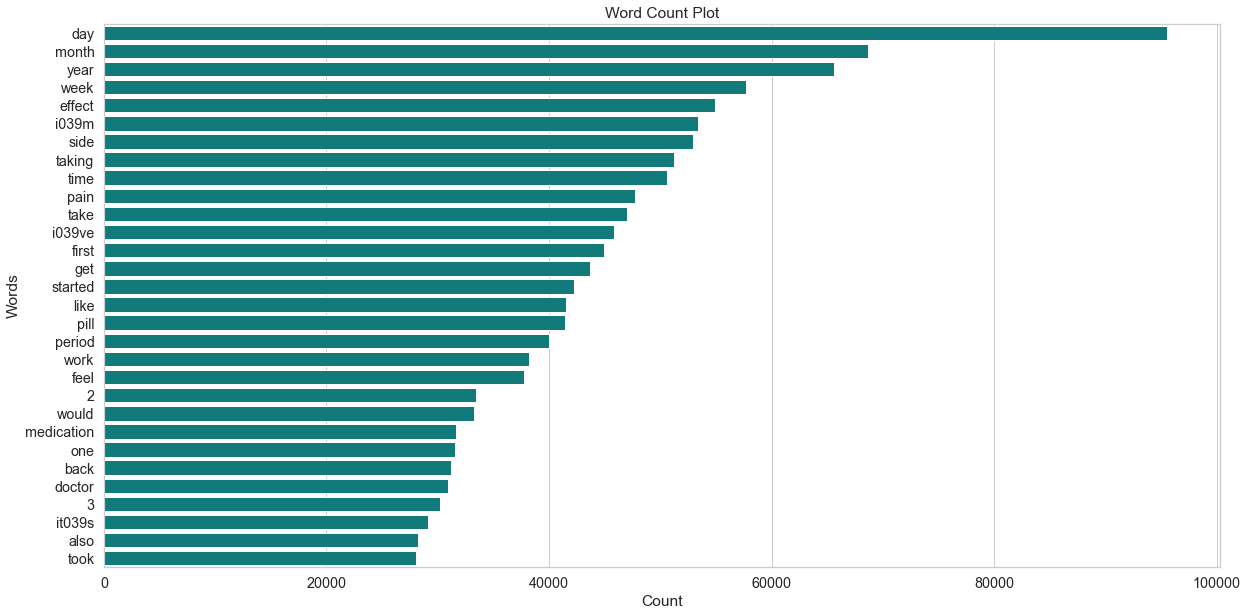

In [30]:
reviews = ' '.join([' '.join(review) for review in df['review']])
frequency = Counter(word_tokenize(reviews))
df_freq = pd.DataFrame(frequency.most_common(30))

plt.rcParams['figure.figsize'] = [20, 10]
sns.set(font_scale = 1.3, style = 'whitegrid')

# plotting
word_count = sns.barplot(x = df_freq[1], y = df_freq[0], color = 'darkcyan')
word_count.set_title("Word Count Plot")
word_count.set_ylabel("Words")
word_count.set_xlabel("Count");
plt.savefig("Images_Ass/word_count-plot.png")

In [31]:
df.head()

uniqueID                  drugName                     condition  \
0    206461                 Valsartan  Left Ventricular Dysfunction   
1     95260                Guanfacine                          ADHD   
2     92703                    Lybrel                 Birth Control   
3    138000                Ortho Evra                 Birth Control   
4     35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  [side, effect, take, combination, bystolic, 5,...       9 2012-05-20   
1  [son, halfway, fourth, week, intuniv, became, ...       8 2010-04-27   
2  [used, take, another, oral, contraceptive, 21,...       5 2009-12-14   
3  [first, time, using, form, birth, control, i03...       8 2015-11-03   
4  [suboxone, completely, turned, life, around, f...       9 2016-11-27   

   usefulCount                                 unprocessed_review  
0           27  "It has no side effect, I take it in combinati...  
1          192  "My son is halfway through his fourth week of ...  
2           17  "I used to take another oral contraceptive, wh...  
3           10  "This is my first time using any form of birth...  
4           37  "Suboxone has completely turned my life around...

### Feature Engineering

In [32]:
df['count_word']=df.review.apply(lambda x: len(str(x).split()))

df['count_unique_word']=df.review.apply(lambda x: len(set(str(x).split())))

df['count_letters']=df.review.apply(lambda x: len(str(x)))

df["count_punctuations"] = df.unprocessed_review.apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

df["count_words_upper"] = df.unprocessed_review.apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

df["count_words_title"] = df.unprocessed_review.apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

df["count_stopwords"] = df.unprocessed_review.apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

df["mean_word_len"] = df.review.apply(lambda x: np.mean([len(w) for w in str(x).split()]))

#### Description of DataFrame Feature Engineering Columns:


- **count_word:** The total number of words in each records review column.
- **count_unique_word:** The total number of unique words in each records review column.
- **count_letters:** The total number of characters (including spaces and punctuation) in each records review column.
- **count_punctuations:** The total number of punctuation characters in each record's 'unprocessed_review' column.
- **count_words_upper:** The number of uppercase words in the 'unprocessed_review' field for each entry.
- **count_words_title:** The number of words in each record's 'unprocessed_review' column in title case (i.e., the word's initial letter is uppercase).
- **count_stopwords:** The number of frequently used (stop words) in each record's 'unprocessed_review' field.



In [33]:
df.head()

uniqueID                  drugName                     condition  \
0    206461                 Valsartan  Left Ventricular Dysfunction   
1     95260                Guanfacine                          ADHD   
2     92703                    Lybrel                 Birth Control   
3    138000                Ortho Evra                 Birth Control   
4     35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  [side, effect, take, combination, bystolic, 5,...       9 2012-05-20   
1  [son, halfway, fourth, week, intuniv, became, ...       8 2010-04-27   
2  [used, take, another, oral, contraceptive, 21,...       5 2009-12-14   
3  [first, time, using, form, birth, control, i03...       8 2015-11-03   
4  [suboxone, completely, turned, life, around, f...       9 2016-11-27   

   usefulCount                                 unprocessed_review  count_word  \
0           27  "It has no side effect, I take it in combinati...           9   
1          192  "My son is halfway through his fourth week of ...          66   
2           17  "I used to take another oral contraceptive, wh...          73   
3           10  "This is my first time using any form of birth...          43   
4           37  "Suboxone has completely turned my life around...          62   

   count_unique_word  count_letters  count_punctuations  count_words_upper  \
0                  9             79                   3                  1   
1                 56            621                  23                  2   
2                 54            685                  34                  6   
3                 33            380                  15                  4   
4                 56            647                  28                  7   

   count_words_title  count_stopwords  mean_word_len  
0                  6                7       7.888889  
1                 13               69       8.424242  
2                 15               59       8.397260  
3                  9               45       7.860465  
4                 15               60       9.451613

In [34]:
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

In [35]:
df.head()

uniqueID                  drugName                     condition  \
0    206461                 Valsartan  Left Ventricular Dysfunction   
1     95260                Guanfacine                          ADHD   
2     92703                    Lybrel                 Birth Control   
3    138000                Ortho Evra                 Birth Control   
4     35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  [side, effect, take, combination, bystolic, 5,...       9 2012-05-20   
1  [son, halfway, fourth, week, intuniv, became, ...       8 2010-04-27   
2  [used, take, another, oral, contraceptive, 21,...       5 2009-12-14   
3  [first, time, using, form, birth, control, i03...       8 2015-11-03   
4  [suboxone, completely, turned, life, around, f...       9 2016-11-27   

   usefulCount                                 unprocessed_review  count_word  \
0           27  "It has no side effect, I take it in combinati...           9   
1          192  "My son is halfway through his fourth week of ...          66   
2           17  "I used to take another oral contraceptive, wh...          73   
3           10  "This is my first time using any form of birth...          43   
4           37  "Suboxone has completely turned my life around...          62   

   count_unique_word  count_letters  count_punctuations  count_words_upper  \
0                  9             79                   3                  1   
1                 56            621                  23                  2   
2                 54            685                  34                  6   
3                 33            380                  15                  4   
4                 56            647                  28                  7   

   count_words_title  count_stopwords  mean_word_len  day  month  year  
0                  6                7       7.888889   20      5  2012  
1                 13               69       8.424242   27      4  2010  
2                 15               59       8.397260   14     12  2009  
3                  9               45       7.860465    3     11  2015  
4                 15               60       9.451613   27     11  2016

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: scalar or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-caps'}
  fontweight or weight: {a

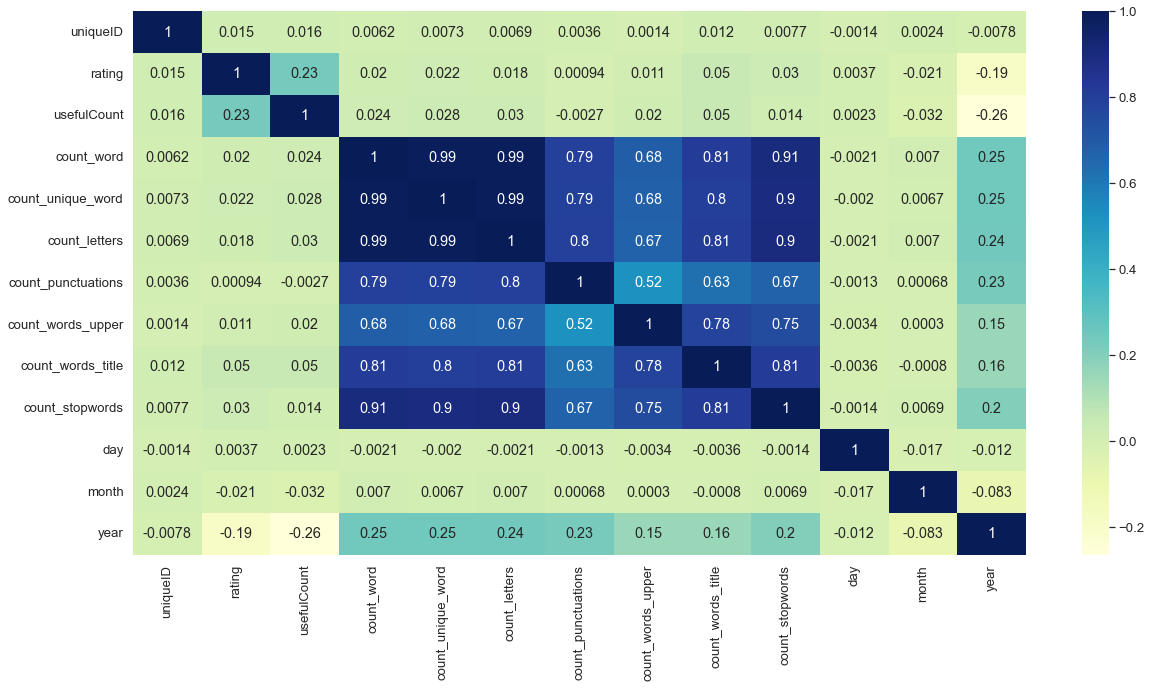

In [36]:
plt.rcParams['figure.figsize'] = [20,10]
sns.set(font_scale = 1.2)
corr = df.select_dtypes(include = 'int64').corr()
corr_plt = sns.heatmap(corr, annot = True, cmap = 'YlGnBu')
plt.setp(corr_plt.get_xticklabels())
plt.savefig("Images_Ass/corr.png")

#### Observation: 

**Content of the Review:**

- The positive association between count_word, count_unique_word, and count_letters is expected. As the number of words in a review grows, so will the number of unique words and total letters.
- count_word (as well as count_unique_word and count_letters) exhibits a strong positive association with count_stopwords, count_words_title, and count_punctuations, implying that as reviews get longer, they naturally contain more of these components.


**Utility and Sentiment:**

- The rating has a weak yet significant positive association with usefulCount. This shows that people may find higher-rated reviews more valuable, but other factors will likely influence a review's perceived usefulness.
- The rating also has a negative association with the year, meaning that the average rating may have deteriorated with time.

**Review Style:**
- count_words_upper shows a high link with count_word, count_unique_word, and count_letters, implying that longer reviews may utilize more capitalized words for emphasis.
- The inverse relationship between mean_word_len and numerous word count variables (count_word, count_unique_word, and so on) suggests that reviews with shorter average word lengths may be longer overall.

**Temporal Features:**
- month and year have a weak but significant negative association. This may indicate specific trends in data gathering or user behaviour over time, but it is not a dominant tendency.
- The negative association between rating and year shows that ratings may drop as the years go. This could be attributed to a variety of factors, including newer medications with more adverse effects, shifting user demographics, or a shift in the platform's user base.


### Encoding Features

In [37]:
label_encoder = {}
for feature in ['drugName', 'condition']:
    label_encoder[feature] = LabelEncoder()
    df[feature] = label_encoder[feature].fit_transform(df[feature])

In [38]:
df.head()

uniqueID  drugName  condition  \
0    206461      3203        466   
1     95260      1431         73   
2     92703      1854        165   
3    138000      2285        165   
4     35696       516        574   

                                              review  rating       date  \
0  [side, effect, take, combination, bystolic, 5,...       9 2012-05-20   
1  [son, halfway, fourth, week, intuniv, became, ...       8 2010-04-27   
2  [used, take, another, oral, contraceptive, 21,...       5 2009-12-14   
3  [first, time, using, form, birth, control, i03...       8 2015-11-03   
4  [suboxone, completely, turned, life, around, f...       9 2016-11-27   

   usefulCount                                 unprocessed_review  count_word  \
0           27  "It has no side effect, I take it in combinati...           9   
1          192  "My son is halfway through his fourth week of ...          66   
2           17  "I used to take another oral contraceptive, wh...          73   
3           10  "This is my first time using any form of birth...          43   
4           37  "Suboxone has completely turned my life around...          62   

   count_unique_word  count_letters  count_punctuations  count_words_upper  \
0                  9             79                   3                  1   
1                 56            621                  23                  2   
2                 54            685                  34                  6   
3                 33            380                  15                  4   
4                 56            647                  28                  7   

   count_words_title  count_stopwords  mean_word_len  day  month  year  
0                  6                7       7.888889   20      5  2012  
1                 13               69       8.424242   27      4  2010  
2                 15               59       8.397260   14     12  2009  
3                  9               45       7.860465    3     11  2015  
4                 15               60       9.451613   27     11  2016

In [39]:
df.drop(columns=['uniqueID', 'date', 'unprocessed_review'], inplace=True)

### TF-IDF Vectorization

In [40]:
df['review'] = [' '.join(review) for review in df['review']]
tfidf_review = TfidfVectorizer(max_features=1500)
review_matrix = tfidf_review.fit_transform(df['review'])
review_df = pd.DataFrame(review_matrix.toarray(), columns=tfidf_review.get_feature_names_out())
data_final = pd.concat([df.drop(columns=['review']), review_df], axis=1)

- The code begins by changing the df dataframe's'review' column, translating each review into a single string. The written reviews are then converted into a numerical format using the Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer. The TfidfVectorizer is initialized with max_features=1500, which implies it will only consider the top 1500 terms in the corpus, ordered by term frequency. This method aids in lowering the dataset's dimensionality by focusing on the most critical words while filtering out some of the noise or less relevant phrases. The resulting matrix is then turned into a data frame, review_df, which is then concatenated with the original df (without the'review' column) to produce data_final, a data frame enriched with the reviews' TF-IDF properties.

- By selecting only 1500 features, I am attempting to compromise between obtaining the essential information from the reviews and managing computational complexity and memory utilization, which is especially important when dealing with massive datasets.


In [41]:
data_final.shape

(161297, 1515)

In [42]:
data_final.head()

drugName  condition  rating  usefulCount  count_word  count_unique_word  \
0      3203        466       9           27           9                  9   
1      1431         73       8          192          66                 56   
2      1854        165       5           17          73                 54   
3      2285        165       8           10          43                 33   
4       516        574       9           37          62                 56   

   count_letters  count_punctuations  count_words_upper  count_words_title  \
0             79                   3                  1                  6   
1            621                  23                  2                 13   
2            685                  34                  6                 15   
3            380                  15                  4                  9   
4            647                  28                  7                 15   

   ...  yesterday  yet   yi  you039ll  you039re  young   yr  zero  zoloft  \
0  ...        0.0  0.0  0.0       0.0  0.000000    0.0  0.0   0.0     0.0   
1  ...        0.0  0.0  0.0       0.0  0.000000    0.0  0.0   0.0     0.0   
2  ...        0.0  0.0  0.0       0.0  0.000000    0.0  0.0   0.0     0.0   
3  ...        0.0  0.0  0.0       0.0  0.000000    0.0  0.0   0.0     0.0   
4  ...        0.0  0.0  0.0       0.0  0.128432    0.0  0.0   0.0     0.0   

   zombie  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  

[5 rows x 1515 columns]

### Splitting dataset into train and test

In [43]:
X = data_final.drop(['rating'], axis=1)
y = data_final['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train.shape, X_test.shape

((120972, 1514), (40325, 1514))

### Modelling

**Logistic Regression**

In [44]:
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)
logreg_train_score = logreg_model.score(X_train, y_train)
logreg_test_score = logreg_model.score(X_test, y_test)
logreg_predictions = logreg_model.predict(X_test)
logreg_confusion = confusion_matrix(y_test, logreg_predictions)
logreg_classification_report = classification_report(y_test, logreg_predictions)

print("Logistic Regression Train Score:", logreg_train_score)
print("Logistic Regression Test Score:", logreg_test_score)
print("Logistic Regression Classification Report:\n", logreg_classification_report)

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Train Score: 0.3154862282181001
Logistic Regression Test Score: 0.3176937383756975
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00      5428
           2       0.00      0.00      0.00      1742
           3       0.00      0.00      0.00      1667
           4       0.00      0.00      0.00      1196
           5       0.00      0.00      0.00      1978
           6       0.00      0.00      0.00      1648
           7       0.00      0.00      0.00      2413
           8       0.00      0.00      0.00      4677
           9       0.19      0.00      0.00      6762
          10       0.32      1.00      0.48     12814

    accuracy                           0.32     40325
   macro avg       0.05      0.10      0.05     40325
weighted avg       0.13      0.32      0.15     40325



C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Result:**
- With training and test scores barely above 0.31, the Logistic Regression model performs poorly. The model is significantly biased towards predicting the '10' class, as evidenced by its recall of 1.00 for that class. At the same time, it fails to generate any significant predictions for the other courses (with precision, memory, and f1-scores mostly being 0). This indicates a considerable class imbalance problem or an insufficient model configuration.


**Decision Tree Classifier**

In [45]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
dt_train_score = dt_model.score(X_train, y_train)
dt_test_score = dt_model.score(X_test, y_test)
dt_predictions = dt_model.predict(X_test)
dt_confusion = confusion_matrix(y_test, dt_predictions)
dt_classification_report = classification_report(y_test, dt_predictions)

print("Decision Tree Train Score:", dt_train_score)
print("Decision Tree Test Score:", dt_test_score)
print("Decision Tree Classification Report:\n", dt_classification_report)

Decision Tree Train Score: 1.0
Decision Tree Test Score: 0.5741351518908866
Decision Tree Classification Report:
               precision    recall  f1-score   support

           1       0.60      0.61      0.61      5428
           2       0.48      0.46      0.47      1742
           3       0.51      0.47      0.49      1667
           4       0.48      0.45      0.46      1196
           5       0.50      0.46      0.48      1978
           6       0.50      0.44      0.46      1648
           7       0.48      0.46      0.47      2413
           8       0.51      0.51      0.51      4677
           9       0.53      0.54      0.54      6762
          10       0.67      0.70      0.68     12814

    accuracy                           0.57     40325
   macro avg       0.52      0.51      0.52     40325
weighted avg       0.57      0.57      0.57     40325



**Result:**
- As shown by a flawless training score of 1.0 compared to a significantly lower test score of 0.57, the Decision Tree model is overfitting the training data. Despite this, the model performs very well across classes, with precision, recall, and f1-score values typically ranging between 0.45 and 0.67, although there is potential for improvement, particularly in middle-tier courses.


**Random Forest Classifier**

In [46]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_train_score = rf_model.score(X_train, y_train)
rf_test_score = rf_model.score(X_test, y_test)
rf_predictions = rf_model.predict(X_test)
rf_confusion = confusion_matrix(y_test, rf_predictions)
rf_classification_report = classification_report(y_test, rf_predictions)

print("Random Forest Train Score:", rf_train_score)
print("Random Forest Test Score:", rf_test_score)
print("Random Forest Classification Report:\n", rf_classification_report)

Random Forest Train Score: 1.0
Random Forest Test Score: 0.6663856168629883
Random Forest Classification Report:
               precision    recall  f1-score   support

           1       0.65      0.78      0.71      5428
           2       0.99      0.46      0.62      1742
           3       0.99      0.47      0.63      1667
           4       1.00      0.45      0.62      1196
           5       0.98      0.46      0.62      1978
           6       1.00      0.44      0.61      1648
           7       1.00      0.45      0.62      2413
           8       0.86      0.47      0.61      4677
           9       0.78      0.49      0.60      6762
          10       0.56      0.96      0.70     12814

    accuracy                           0.67     40325
   macro avg       0.88      0.54      0.64     40325
weighted avg       0.76      0.67      0.65     40325



**Result:**
- As seen by a flawless training score of 1.0 vs. a test score of 0.667, the Random Forest model is overfitting the training data. However, it performs significantly better than earlier models. With f1-scores of 0.71, the model is especially good at predicting classes '1' and '10'. Despite great precision (particularly classes 2–8), other classes have low recall, resulting in moderate f1-scores. This implies that, while the model's predictions are reliable when it predicts specific courses, it is frequently hesitant or misses numerous actual instances of these classes.


**MultinomialNaive Bayes**

In [47]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_train_score = nb_model.score(X_train, y_train)
nb_test_score = nb_model.score(X_test, y_test)
nb_predictions = nb_model.predict(X_test)
nb_confusion = confusion_matrix(y_test, nb_predictions)
nb_classification_report = classification_report(y_test, nb_predictions)

print("Multinomial Naive Bayes Train Score:", nb_train_score)
print("Multinomial Naive Bayes Test Score:", nb_test_score)
print("Multinomial Naive Bayes Classification Report:\n", nb_classification_report)

Multinomial Naive Bayes Train Score: 0.18907681116291372
Multinomial Naive Bayes Test Score: 0.1878735275883447
Multinomial Naive Bayes Classification Report:
               precision    recall  f1-score   support

           1       0.20      0.26      0.23      5428
           2       0.06      0.17      0.08      1742
           3       0.06      0.22      0.10      1667
           4       0.04      0.08      0.06      1196
           5       0.08      0.11      0.09      1978
           6       0.00      0.00      0.00      1648
           7       0.07      0.05      0.06      2413
           8       0.14      0.05      0.08      4677
           9       0.21      0.11      0.15      6762
          10       0.42      0.31      0.36     12814

    accuracy                           0.19     40325
   macro avg       0.13      0.14      0.12     40325
weighted avg       0.23      0.19      0.20     40325



C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Result:**
- With training and test scores both below 0.19, the Multinomial Naive Bayes model performs poorly. The model's predictions are distributed thinly over several classes, but it needs help to produce precise forecasts for most of them. The category '10' has the highest f1-score of 0.36, yet even this is subpar. Classes '6' and '8' have inferior precision and recall values, indicating that the model needs help distinguishing and correctly classifying these classes. This model lacks the predictive capabilities required for this dataset and could benefit from more tuning or a new modeling strategy.


**K-Neighbors Classifier**

In [48]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_train_score = knn_model.score(X_train, y_train)
knn_test_score = knn_model.score(X_test, y_test)
knn_predictions = knn_model.predict(X_test)
knn_confusion = confusion_matrix(y_test, knn_predictions)
knn_classification_report = classification_report(y_test, knn_predictions)

print("K-Nearest Neighbors Train Score:", knn_train_score)
print("K-Nearest Neighbors Test Score:", knn_test_score)
print("K-Nearest Neighbors Classification Report:\n", knn_classification_report)

K-Nearest Neighbors Train Score: 0.4730598816255001
K-Nearest Neighbors Test Score: 0.25063856168629883
K-Nearest Neighbors Classification Report:
               precision    recall  f1-score   support

           1       0.22      0.39      0.28      5428
           2       0.07      0.06      0.07      1742
           3       0.06      0.04      0.05      1667
           4       0.04      0.03      0.03      1196
           5       0.07      0.04      0.05      1978
           6       0.05      0.02      0.03      1648
           7       0.07      0.03      0.05      2413
           8       0.15      0.12      0.13      4677
           9       0.20      0.20      0.20      6762
          10       0.41      0.44      0.43     12814

    accuracy                           0.25     40325
   macro avg       0.13      0.14      0.13     40325
weighted avg       0.23      0.25      0.24     40325



**Result:**
- The K-Nearest Neighbours (KNN) model overfits the training data, as demonstrated by a training score of 0.473 versus a test score of 0.2506. Except for class '10', which has a f1-score of 0.43, the model needs help to predict most types with high precision and recall. However, even this is not particularly impressive. Courses with low f1-scores include '2', '3', '4', '5', and '6', demonstrating the model's difficulties in identifying and correctly classifying these classes. The overall performance of the KNN model needs to be improved for this dataset, indicating the need for hyperparameter adjustment or alternate modeling methodologies.


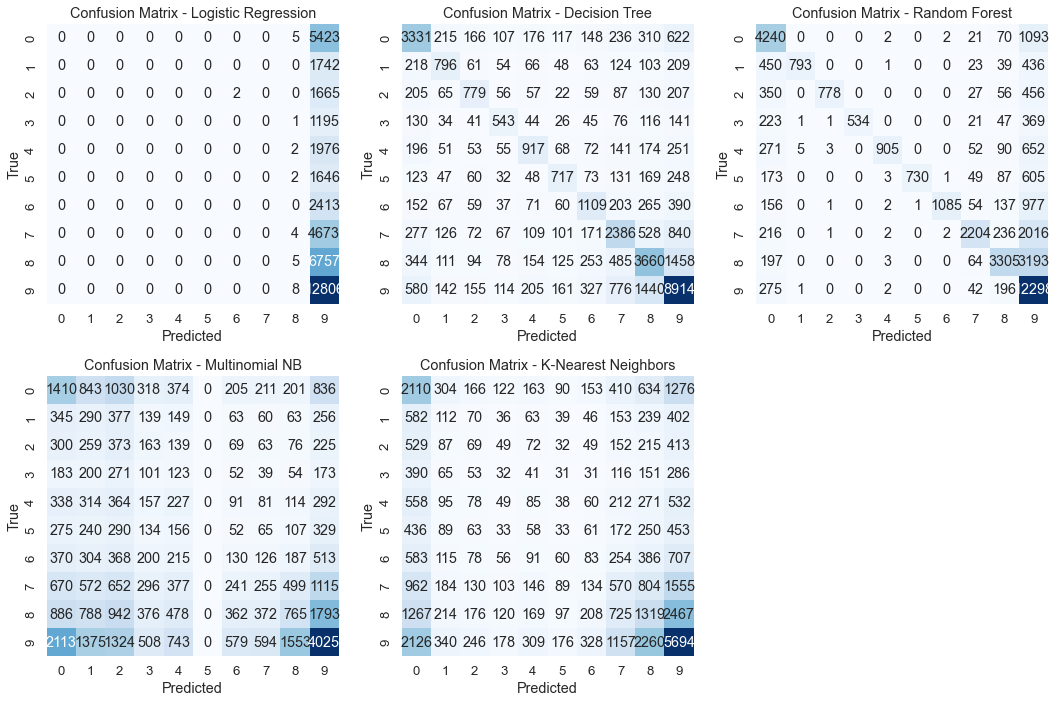

In [49]:
classifiers = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Multinomial NB', 'K-Nearest Neighbors']
confusion_matrices = [logreg_confusion, dt_confusion, rf_confusion, nb_confusion, knn_confusion]

plt.figure(figsize=(15, 10))
for i, matrix in enumerate(confusion_matrices):
    plt.subplot(2, 3, i + 1)
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {classifiers[i]}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f"Images_Ass/Confusion Matrix - {classifiers[i]}.png")
plt.tight_layout()
plt.show()

### Cunfusion Matrixs Observation:
**1. Logistic Regression Confusion (logreg_confusion):**
- Most predictions are focused on the last class (index 9). Other courses have a low number of correct predictions, suggesting poor performance. The model is skewed towards predicting the dominating class.

**2. Decision Tree (dt_confusion):**
- The diagonal elements representing correct predictions are more evenly distributed than in Logistic Regression. This shows that the Decision Tree retains more distinctions across classes but favors guessing the last type.

**3. Random Forest Confusion (rf_confusion):**
- The more significant amounts along the diagonal indicate that this model outperforms the Decision Tree. However, as with the Logistic Regression and Decision Tree models, there is a considerable bias toward the last class.

**4. Naive Bayes (nb_confusion):**
- Like Logistic Regression, this model exhibits a bias towards the last class. It delivers a diverse set of predictions across classes, albeit the diagonal elements (right predictions) are lower than one may expect.

**5. K-Nearest Neighbours (knn_confusion):** 
- KNN predicts in a somewhat balanced manner across classes. Although the last class has a greater prediction rate, it only dominates the forecasts for other classes as much as in past models.

**Overall:**
- All models are biased towards the last class, implying that the dataset is imbalanced with a higher proportion of samples from the previous category. Random Forest and K-Nearest Neighbours handle this bias better than the other models, although there is still space for improvement. Techniques such as resampling, class weighting, or employing other evaluation metrics may help to improve model performance on such data.

### SMOTE

- To deal with the dataset's imbalance, we can employ the Synthetic Minority Over-sampling Technique (SMOTE). SMOTE generates synthetic samples in the feature space. It selects k of the nearest neighbors for each sample in the minority class, selects one at random, and generates similar but randomly altered new examples.


In [50]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#### Random Forest Classifier

In [51]:
rf = RandomForestClassifier(max_depth=10, n_estimators=10, random_state=42)
rf.fit(X_train_smote, y_train_smote)

rf_train_score = rf.score(X_train_smote, y_train_smote)
rf_test_score = rf.score(X_test, y_test)
rf_predictions = rf.predict(X_test)
rf_confusion = confusion_matrix(y_test, rf_predictions)
rf_report = classification_report(y_test, rf_predictions)
print("Random Forest Classifier Train Score:", rf_train_score)
print("Random Forest Classifier Test Score:", rf_test_score)
print("Random Forest Classifier Classification Report:\n", rf_report)

Random Forest Classifier Train Score: 0.3301453831041257
Random Forest Classifier Test Score: 0.3447737135771854
Random Forest Classifier Classification Report:
               precision    recall  f1-score   support

           1       0.35      0.40      0.38      5428
           2       0.16      0.09      0.12      1742
           3       0.15      0.09      0.12      1667
           4       0.14      0.11      0.12      1196
           5       0.12      0.05      0.07      1978
           6       0.13      0.07      0.09      1648
           7       0.15      0.07      0.09      2413
           8       0.22      0.07      0.10      4677
           9       0.28      0.08      0.13      6762
          10       0.40      0.78      0.53     12814

    accuracy                           0.34     40325
   macro avg       0.21      0.18      0.17     40325
weighted avg       0.29      0.34      0.28     40325



#### **Results:**
**Overall Performance:**
- The Random Forest model's overall accuracy after employing SMOTE is 34.48%. This is not exceptionally high, indicating that the model needs help correctly classifying a large number of observations.

**Class Imbalance:**
- SMOTE rectified the class imbalance, but the findings show that while the data imbalance may have been fixed, the classifier is still ineffective at discriminating between the distinct classes.

**Performance in Different Classes:**

- Class 10 had the highest recall (0.78), meaning that the model identified 78% of the actual instances of this class accurately. However, because this class has the most support (number of actual occurrences in the test set), the model may be biased toward predicting this class more frequently than others.

- Class 1 has a balanced precision and recall, indicating a satisfactory performance.

- Classes 2–9 have poorer recall values, indicating that the model frequently overlooks real examples of these classes. The precision for these classes is also low, meaning that wit is frequently inaccurate hen the model predicts that an instance belongs to one of these classes.

**Precision and Recall Trade-off:** 
- For most classes, the f1-score, which is the harmonic mean of precision and recall, is low, indicating a significant trade-off. In other words, many correct predictions (accuracy) for a class frequently come at the expense of losing out on other actual instances of that class (recall) and vice versa.


**Conclusion:**
- In conclusion, while SMOTE has corrected the class imbalance, the RandomForest classifier still performs poorly. To improve the model's predictive capability, further refinement in preprocessing, feature engineering, or experimenting with other algorithms may be required.



### Refinement in Preprocessing 

##### Word2Vec

In [55]:
from gensim.models import Word2Vec

tokenized_corpus = df['review'].apply(lambda x: x.split())

model = Word2Vec(sentences=tokenized_corpus, vector_size=200, window=5, workers=4, min_count=1)
model.train(tokenized_corpus, total_examples=len(tokenized_corpus), epochs=100)

def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model.wv[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

wordvec_arrays = np.zeros((len(tokenized_corpus), 200))
for i in range(len(tokenized_corpus)):
    wordvec_arrays[i, :] = word_vector(tokenized_corpus[i], 200)
wordvec_df = pd.DataFrame(wordvec_arrays)

#### PCA

In [61]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42) # retaining 95% variance
wordvec_pca = pca.fit_transform(wordvec_df)

wordvec_pca_df = pd.DataFrame(wordvec_pca)

### Refinement in Feature Selection

In [62]:
from sklearn.feature_selection import RFE

X = wordvec_pca_df
y = df['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf_classifier = RandomForestClassifier(random_state=42)
rfe = RFE(estimator=rf_classifier, n_features_to_select=50, step=10, verbose=1)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

Fitting estimator with 138 features.
Fitting estimator with 128 features.
Fitting estimator with 118 features.
Fitting estimator with 108 features.
Fitting estimator with 98 features.
Fitting estimator with 88 features.
Fitting estimator with 78 features.
Fitting estimator with 68 features.
Fitting estimator with 58 features.


In [74]:
print("Total number of fetures: ",rfe.n_features_in_)
print("Selected fetures: ",rfe.n_features_)

Total number of fetures:  138
Selected fetures:  50


### Performing Random Forest Classification

In [63]:
rf_classifier.fit(X_train_rfe, y_train)

rf_train_score = rf_classifier.score(X_train_rfe, y_train)
rf_test_score = rf_classifier.score(X_test_rfe, y_test)
rf_predictions = rf_classifier.predict(X_test_rfe)
rf_confusion = confusion_matrix(y_test, rf_predictions)
rf_report = classification_report(y_test, rf_predictions)

print("Random Forest Classifier Train Score:", rf_train_score)
print("Random Forest Classifier Test Score:", rf_test_score)
print("Random Forest Classifier Classification Report:\n", rf_report)

Random Forest Classifier Train Score: 0.9979850740485288
Random Forest Classifier Test Score: 0.6774023558586485
Random Forest Classifier Classification Report:
               precision    recall  f1-score   support

           1       0.67      0.75      0.71      4324
           2       0.98      0.49      0.65      1386
           3       0.99      0.52      0.68      1303
           4       0.99      0.52      0.68      1002
           5       0.98      0.47      0.64      1603
           6       0.99      0.48      0.64      1269
           7       0.98      0.48      0.65      1891
           8       0.80      0.49      0.61      3778
           9       0.70      0.55      0.62      5506
          10       0.58      0.94      0.72     10198

    accuracy                           0.68     32260
   macro avg       0.87      0.57      0.66     32260
weighted avg       0.74      0.68      0.67     32260



### Results:

- **Overfitting:** Overfitting occurs when the model performs very well on the training data (train score: 0.998), but much worse on the test data (test score: 0.677), indicating overfitting.

- **Imbalance in Class:** Some classes have more data than others, which affects precision and recall. Classes with more help tend to perform better.

- **Precision and Recall Scores Vary:** Precision and recall scores vary between classes. Certain classes are accurately predicted (for example, class 10) whereas others struggle (for example, classes 2, 3, 4).

- **F1-Score Balance:** F1-scores vary between courses, showing different trade-offs between precision and recall.

- **Average F1-Scores:** Classes with lower support influence the weighted average F1-score (0.67), influencing the overall performance rating.
- **Potential Improvement:** Model performance for classes with poorer precision and recall could be improved utilizing hyperparameter tuning or more advanced models.

- **Distinct Class 10 Prediction:** Class 10 is distinguished. Class 10 has a high precision and recall, indicating a significant separation from the other classes.


Text(154.5, 0.5, 'True')

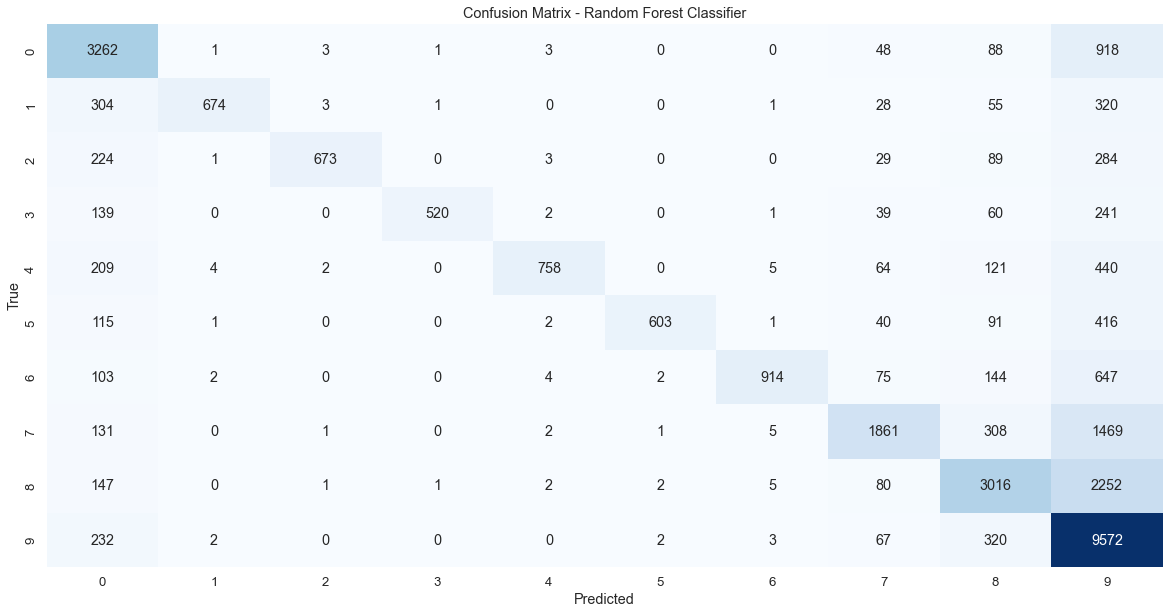

In [64]:
sns.heatmap(rf_confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix - Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')

##### Observation:

- **Correct Classifications:** From top-left to bottom-right, the diagonal elements represent the number of correct forecasts for each class. These are genuine positives, in which the projected class corresponds to the actual class.

- **Misclassifications:** Misclassifications are indicated by values outside the diagonal. For example, the value in row 1, column 2 (1) indicates that one instance from class 1 was misclassified as class 2.

- **Impact of Class Imbalance:** The numbers in the matrix show that the model predicts classes with higher support (more significant numbers) better than classes with lower support (smaller numbers). This is a regular occurrence in skewed datasets.
- **Class 10:** Class 10 appears to have the most correct predictions (bottom-right corner), indicating that the model is extremely effective at predicting this class.

- **Misclassification Patterns:** Based on the off-diagonal values, you can see which classes are frequently confused with others. Class 9 is sometimes confused with class 10, as evidenced by the value in row 9, column 10.



## In Conclusion

- We went on a thorough data science journey in our Jupyter Notebook, beginning with exploratory data analysis (EDA) and visualisation. This first step offered a thorough grasp of the dataset's structure, distribution, and probable anomalies.

- Because textual data made up a large component of the dataset, considerable preparation was required. Tokenization, lemmatization, stopword removal, and punctuation exclusion were all used to prepare the text data for further analysis.

- Given the categorical character of some variables, label encoding was utilised to convert them to a numerical representation, assuring compatibility with machine learning methods.

- TF-IDF vectorization was used to convert the preprocessed text into a format suitable for machine learning. This method efficiently converted the text into numerical vectors while simultaneously emphasising the relevance of less common, more informative phrases.

- When we got into the modelling phase, we discovered a recurring issue: class imbalance. This constituted a risk because models in such situations frequently demonstrate a bias towards the majority class. The Synthetic Minority Over-sampling Technique (SMOTE) was used to address issue. SMOTE intended to equalise the number of instances across classes by generating synthetic examples in the feature space.

- Following that, several categorization models were trained and tested. Although several models demonstrated promise, there was opportunity for development, particularly in dealing with the complexities of textual data. Following the deployment of SMOTE, the Random Forest classifier displayed considerable improvements in its performance measures, suggesting the impact of resolving data imbalance.

- We increased Random Forest classification performance by refining the preprocessing pipeline by using Word2Vec for text representation and PCA, followed by Recursive Feature Elimination (RFE) for feature selection.

- In conclusion, this notebook exemplifies the multidimensional nature of data science initiatives, particularly when working with unstructured data such as text. While great progress was made, the journey demonstrated the value of continual iteration and refining. To boost performance, further steps could include going deeper into hyperparameter tweaking, experimenting with sophisticated text representation approaches, or even investigating deep learning models.
